# **01: Exploratory Data Analysis for the DROO Project**

### **Overall Project Goal**

The ultimate goal of the **Deep Reinforcement Learning for Online Offloading** project is to train an intelligent agent that makes real-time offloading decisions for multiple wireless devices connected to a Mobile Edge Computing (MEC) server. For every computation task, the agent must decide whether a device should **process it locally** or **offload it to the server**, aiming to maximize the overall network performance (the weighted sum computation rate).

---

### **The Purpose of This Notebook: Building the Foundation**

This notebook is the crucial first step in our project: **Exploratory Data Analysis (EDA)**.

Before we can build an intelligent agent, we must first deeply understand the problem it is trying to solve. Think of this as a detective studying the crime scene before identifying a suspect. We will load the project's data, verify its integrity, and create a series of visualizations to answer key questions about the environment and the optimal behavior within it.

> **We are not training any models here.** We are simply understanding the ground we're standing on to ensure we build our DRL agent on a solid, data-driven foundation.

---

### **The Dataset**

The dataset (`data_10.mat`) is unique because it contains not just raw environmental data, but also the **pre-calculated optimal solutions** found by a traditional, non-real-time optimization algorithm. This "perfect" data serves as our **ground truth** or **"oracle" benchmark**. Our DRL agent will later attempt to learn a policy that mimics this optimal behavior in real-time.

Our key data components include:
-   `input_h`: The **state** of the environment (wireless channel gains for each user).
-   `output_mode`: The **optimal action** (0 for Local, 1 for Offload).
-   `output_obj`: The **optimal outcome** (the maximum possible computation rate).

### **Notebook Workflow**

This analysis will follow a structured narrative to build our understanding layer by layer:
1.  **Setup and High-Level Overview:** Load the data into a Pandas DataFrame and get a full statistical summary.
2.  **Analyzing the Environment:** A deep dive into the wireless channel gains to understand their volatility and characteristics.
3.  **Understanding the "Oracle":** A detailed look at the optimal decisions and performance outcomes.
4.  **Connecting Inputs to Outputs:** The core of our analysis, where we uncover the direct relationships between channel quality and optimal decisions.
5.  **Conclusion & Next Steps:** Summarize our findings into actionable insights that will directly inform the design of our DRL agent.

# **Part 1: Project Setup & High-Level Data Inspection**

---

### **Objective**
The purpose of this notebook is to load, inspect, and visualize the optimal offloading dataset for the DROO project. The goal is to understand the underlying relationships between wireless conditions (inputs) and optimal decisions (outputs). These insights will be crucial for guiding the design, training, and evaluation of our Deep Reinforcement Learning agent.

### **Libraries Used**
We will be using the following Python libraries for our analysis:
- **scipy:** To load the `.mat` data file.
- **numpy:** For numerical operations.
- **pandas:** For creating and managing a structured DataFrame, which is ideal for analysis.
- **matplotlib & seaborn:** For creating high-quality visualizations.

In [2]:
# ===================================================================
# Cell 2: Environment and Dependency Check
# This cell ensures all required packages are installed before we begin.
# ===================================================================
import sys
import subprocess
import importlib

print("--- Checking Project Dependencies ---")
required_packages = ['numpy', 'scipy', 'pandas', 'matplotlib', 'seaborn']

for package in required_packages:
    try:
        importlib.import_module(package)
        print(f"✅ {package} is already installed.")
    except ImportError:
        print(f"❌ {package} not found. Attempting to install...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ Successfully installed {package}.")
        except Exception as e:
            print(f"🚨 Failed to install {package}. Please install it manually. Error: {e}")
            
print("\n--- Dependency check complete. ---")

# --- Import standard libraries for the notebook ---
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set a professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Makes plots more readable

print("\nStandard libraries for the notebook imported successfully.")

--- Checking Project Dependencies ---
✅ numpy is already installed.
✅ scipy is already installed.
✅ pandas is already installed.
✅ matplotlib is already installed.
✅ seaborn is already installed.

--- Dependency check complete. ---

Standard libraries for the notebook imported successfully.


In [3]:
# ===================================================================
# Cell 3: Data Loading and Initial Structuring
# Load the .mat file and inspect the raw data structure.
# ===================================================================

# --- Configuration ---
DATA_PATH = r"./data" # Use the path from your old notebook
USER_COUNT = 10
file_to_load = f'data_{USER_COUNT}.mat'
full_path = os.path.join(DATA_PATH, file_to_load)

# --- Load the Data ---
try:
    mat_data = scipy.io.loadmat(full_path)
    print(f"Successfully loaded '{file_to_load}'")
except FileNotFoundError:
    print(f"🚨 Error: The file was not found at '{full_path}'")
    print("Please make sure the DATA_PATH is correct and the file exists.")
    
# --- Inspect Raw Data Structure ---
print("\nVariables available in the .mat file:", list(mat_data.keys()))

# Extract arrays for easier access
input_h = mat_data['input_h']
output_mode = mat_data['output_mode']
output_a = mat_data['output_a']
output_tau = mat_data['output_tau']
output_obj = mat_data['output_obj']

# Print shapes to verify dimensions
print("\n--- Shapes of Loaded NumPy Arrays ---")
print(f"Shape of channel gains (input_h): {input_h.shape}")
print(f"Shape of optimal actions (output_mode): {output_mode.shape}")
print(f"Shape of optimal computation rate (output_obj): {output_obj.shape}")

num_samples, num_users = input_h.shape
print(f"\nThis dataset contains {num_samples} samples for {num_users} users.")

Successfully loaded 'data_10.mat'

Variables available in the .mat file: ['__header__', '__version__', '__globals__', 'output_a', 'input_h', 'output_mode', 'output_obj', 'output_tau']

--- Shapes of Loaded NumPy Arrays ---
Shape of channel gains (input_h): (30000, 10)
Shape of optimal actions (output_mode): (30000, 10)
Shape of optimal computation rate (output_obj): (30000, 1)

This dataset contains 30000 samples for 10 users.


In [4]:
# ===================================================================
# Cell 4: Conversion to Pandas DataFrame
# We convert the raw NumPy arrays into a single, structured DataFrame.
# This makes analysis, filtering, and visualization much easier.
# ===================================================================

# --- Create Meaningful Column Names ---
h_cols = [f'h_user_{i}' for i in range(num_users)]
mode_cols = [f'mode_user_{i}' for i in range(num_users)]
tau_cols = [f'tau_user_{i}' for i in range(num_users)]

# --- Assemble the DataFrame ---
# Start with the channel gains
df = pd.DataFrame(input_h, columns=h_cols)

# Add the multi-column output data
df[mode_cols] = output_mode
df[tau_cols] = output_tau

# Add the single-column output data
df['a_time'] = output_a
df['Q_optimal'] = output_obj

print("DataFrame created successfully.")

# --- Display the Head of the DataFrame ---
# .head() shows the first 5 rows, giving a clear view of the final structure.
print("\n--- First 5 Rows of the Assembled DataFrame ---")
display(df.head())

DataFrame created successfully.

--- First 5 Rows of the Assembled DataFrame ---


,h_user_0,h_user_1,h_user_2,h_user_3,h_user_4,h_user_5,h_user_6,h_user_7,h_user_8,h_user_9,...,tau_user_2,tau_user_3,tau_user_4,tau_user_5,tau_user_6,tau_user_7,tau_user_8,tau_user_9,a_time,Q_optimal
0,8.503830e-07,0.000003,2.240548e-06,5.438564e-07,6.129093e-07,0.000001,3.160074e-06,2.198456e-06,1.554499e-07,3.880862e-06,...,0.000000,0.0,0.000000,0.000000,0.062042,0.044113,0.0,0.137465,0.671031,1.510817e+06
1,6.060203e-06,0.000011,1.002135e-07,1.216106e-06,1.961388e-06,0.000002,5.245636e-06,5.895307e-07,4.077694e-06,2.883332e-06,...,0.000000,0.0,0.000000,0.000000,0.047764,0.000000,0.0,0.000000,0.522350,3.278982e+06
2,5.526906e-06,0.000014,9.333688e-07,7.232916e-07,9.212445e-07,0.000004,7.740953e-07,1.011333e-06,3.535522e-08,4.723955e-07,...,0.000000,0.0,0.000000,0.039640,0.000000,0.000000,0.0,0.000000,0.483011,3.875044e+06
3,1.891654e-06,0.000005,3.898926e-06,6.893430e-07,7.036444e-06,0.000005,3.259650e-06,1.446550e-06,2.383077e-07,2.392343e-07,...,0.047908,0.0,0.156036,0.105264,0.000000,0.000000,0.0,0.000000,0.571649,2.281788e+06
4,2.382791e-05,0.000006,2.979870e-06,3.142213e-06,1.190893e-06,0.000001,2.290130e-06,1.293965e-06,5.378316e-06,1.755316e-08,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.419690,4.140851e+06


In [5]:
# ===================================================================
# Cell 5: High-Level Statistical Summary
# Use the .describe() method to get a full statistical overview of
# every variable in the dataset in a single, clean table.
# ===================================================================

print("--- Full Statistical Summary of the Dataset ---")

# The .T transposes the output, making it easier to read with many columns.
# Each variable gets its own row.
display(df.describe().T)

--- Full Statistical Summary of the Dataset ---


,count,mean,std,min,25%,50%,75%,max
h_user_0,30000.0,8.417797e-06,8.411938e-06,2.019180e-10,2.412613e-06,5.773071e-06,1.180398e-05,8.697021e-05
h_user_1,30000.0,6.197465e-06,6.228969e-06,3.433640e-10,1.761890e-06,4.314717e-06,8.586875e-06,6.305590e-05
h_user_2,30000.0,4.669825e-06,4.668808e-06,2.296171e-10,1.343892e-06,3.244806e-06,6.496032e-06,4.621080e-05
h_user_3,30000.0,3.563280e-06,3.538504e-06,9.776380e-11,1.035490e-06,2.480676e-06,4.954405e-06,3.424764e-05
h_user_4,30000.0,2.821850e-06,2.812665e-06,8.407177e-11,8.135279e-07,1.932664e-06,3.938182e-06,2.809646e-05
h_user_5,30000.0,2.297579e-06,2.295924e-06,2.848381e-10,6.540923e-07,1.597222e-06,3.179269e-06,2.600615e-05
h_user_6,30000.0,1.847116e-06,1.846850e-06,4.422781e-11,5.294225e-07,1.278870e-06,2.565999e-06,1.904982e-05
h_user_7,30000.0,1.534040e-06,1.542955e-06,8.552150e-11,4.384648e-07,1.068599e-06,2.108856e-06,1.465074e-05
h_user_8,30000.0,1.307330e-06,1.304262e-06,3.828829e-11,3.792732e-07,9.037637e-07,1.811921e-06,1.282352e-05
h_user_9,30000.0,1.094493e-06,1.087301e-06,2.975155e-11,3.195282e-07,7.611504e-07,1.530166e-06,1.247483e-05


# **Part 2: Deep Dive into the Agent's Environment - Channel Gains (`input_h`)**

---

### **Cell 6: Distribution of Channel Gains per User**

**Purpose:** To understand and compare the typical signal quality for different users. Are some users consistently in better or worse environments?

**Action:** We will plot the Kernel Density Estimate (KDE) for the channel gains of a few representative users. A KDE plot is a smoothed version of a histogram that helps visualize the probability density of a variable. We'll select users who showed very different offloading behaviors in our initial analysis (e.g., high, medium, and low frequency offloaders).

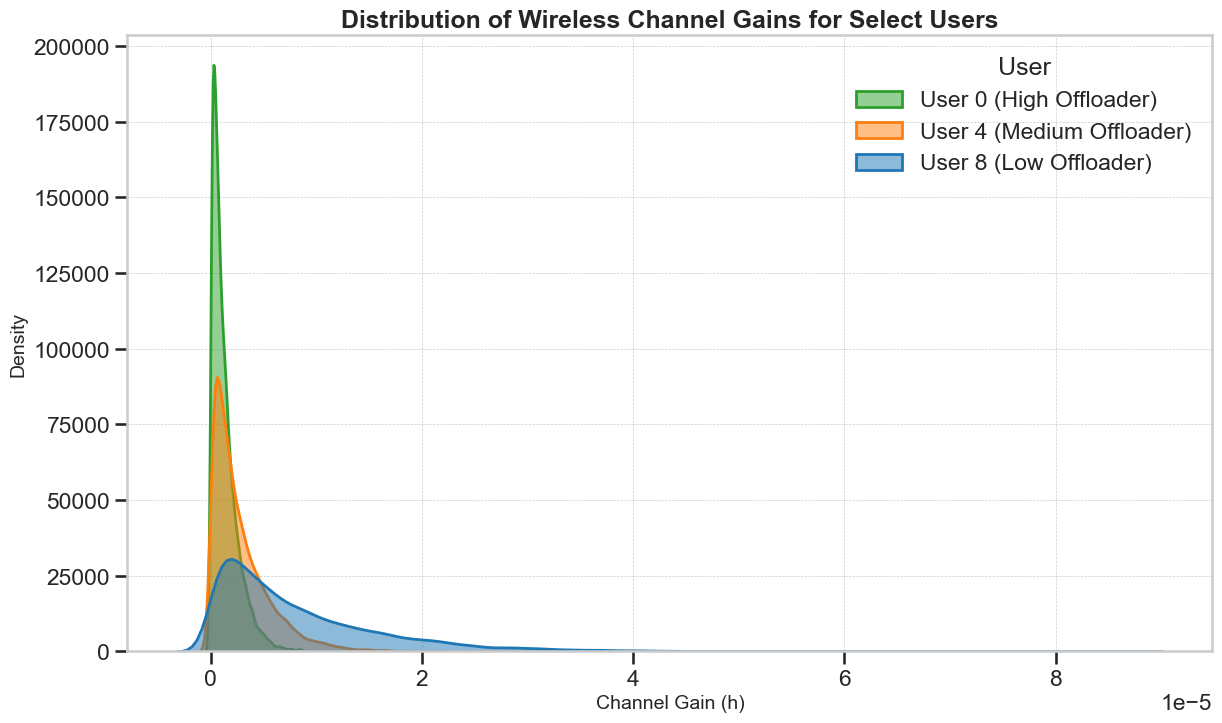

In [6]:
# ===================================================================
# Cell 6: Code for Channel Gain Distribution Plot
# ===================================================================

# --- Select Representative Users ---
# From our previous notebook, we know User 0 offloads frequently, User 8 rarely, and User 4 is somewhere in the middle. This makes them good candidates for comparison.
users_to_plot = ['h_user_0', 'h_user_4', 'h_user_8']

# --- Create the Plot ---
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df[users_to_plot], fill=True, alpha=0.5, linewidth=2)

# --- Add Titles and Labels ---
plt.title('Distribution of Wireless Channel Gains for Select Users', fontsize=18, fontweight='bold')
plt.xlabel('Channel Gain (h)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='User', labels=['User 0 (High Offloader)', 'User 4 (Medium Offloader)', 'User 8 (Low Offloader)'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

**Insight:** The plot clearly shows that different users experience vastly different channel conditions. The distribution for **User 0** is shifted to the right, indicating a higher probability of having stronger channel gains. Conversely, the distribution for **User 8** is heavily skewed towards the left, confirming consistently poor signal quality. This directly supports the idea that a personalized policy is necessary.

### **Cell 7: Time-Series Fluctuation of Channel Gains**

**Purpose:** To visualize how dynamically the wireless environment changes from one moment to the next.

**Action:** We will plot the channel gains for the same selected users over the first 250 time slots. This line chart will reveal the volatility and temporal nature of the signal quality.

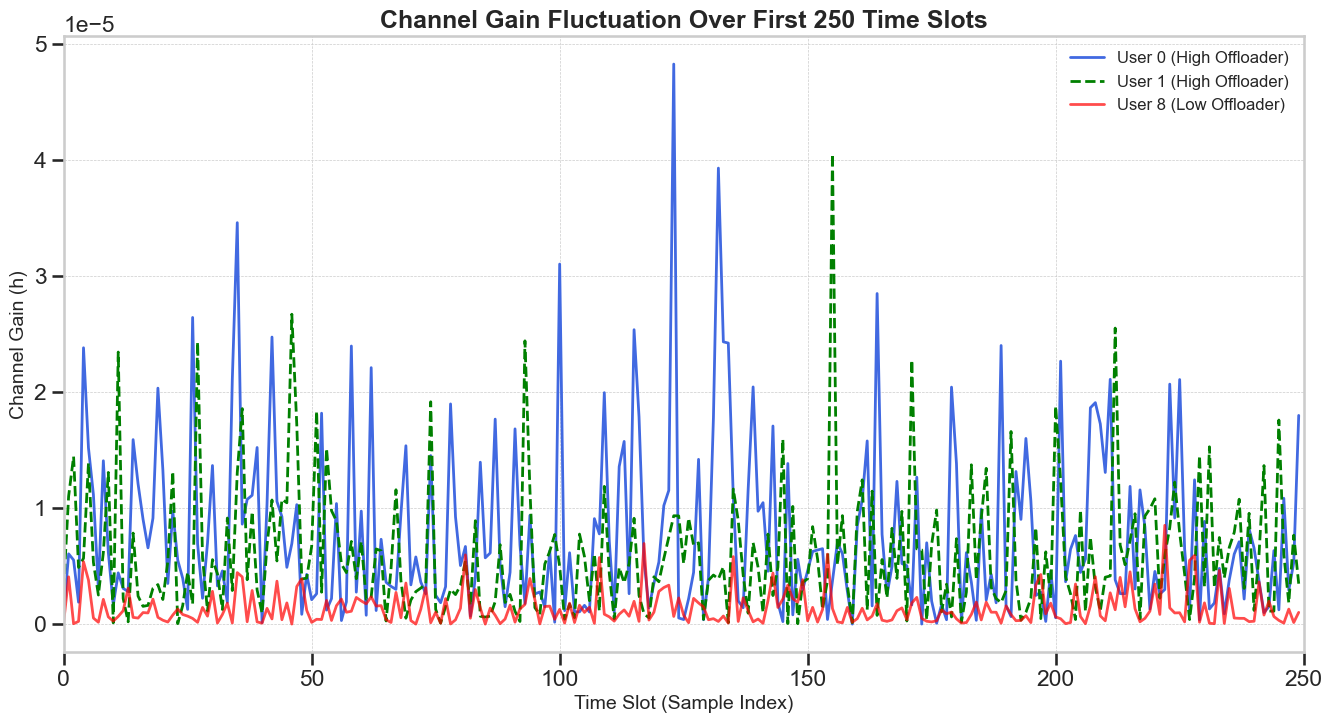

In [7]:
# ===================================================================
# Cell 7: Code for Time-Series Fluctuation Plot
# ===================================================================

# --- Configuration ---
samples_to_plot = 250
users_to_plot = ['h_user_0', 'h_user_1', 'h_user_8'] # User 1 is also a high offloader

# --- Create the Plot ---
plt.figure(figsize=(16, 8))
plt.plot(df.index[:samples_to_plot], df[users_to_plot[0]][:samples_to_plot], label='User 0 (High Offloader)', color='royalblue', linewidth=2)
plt.plot(df.index[:samples_to_plot], df[users_to_plot[1]][:samples_to_plot], label='User 1 (High Offloader)', color='green', linewidth=2, linestyle='--')
plt.plot(df.index[:samples_to_plot], df[users_to_plot[2]][:samples_to_plot], label='User 8 (Low Offloader)', color='red', linewidth=2, alpha=0.7)

# --- Add Titles and Labels ---
plt.title(f'Channel Gain Fluctuation Over First {samples_to_plot} Time Slots', fontsize=18, fontweight='bold')
plt.xlabel('Time Slot (Sample Index)', fontsize=14)
plt.ylabel('Channel Gain (h)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, samples_to_plot)

plt.show()

**Insight:** This graph powerfully demonstrates the high volatility of the wireless channel. The gains for all users fluctuate rapidly and unpredictably. A static offloading strategy would be ineffective in such an environment. This visual evidence strongly justifies the need for an online, adaptive agent that can react to these changes in real-time.

### **Cell 8: Correlation of Channel Gains Between Users**

**Purpose:** To determine if users' channel conditions are independent or if they are influenced by common environmental factors.

**Action:** We will create a correlation matrix for the channel gain columns (`h_user_0` through `h_user_9`) and visualize it as a heatmap.

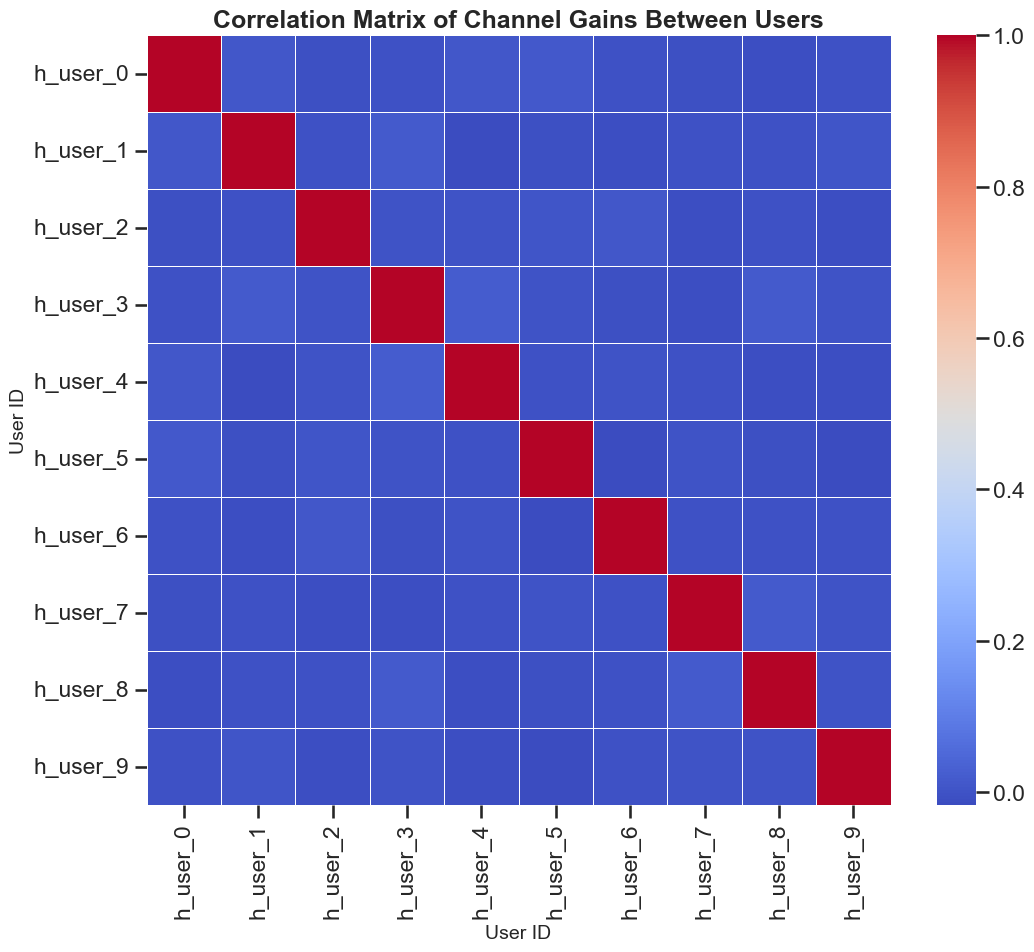

In [8]:
# ===================================================================
# Cell 8: Code for Channel Gain Correlation Heatmap
# ===================================================================

# --- Select only the channel gain columns ---
h_cols = [f'h_user_{i}' for i in range(num_users)]
channel_gain_df = df[h_cols]

# --- Calculate the correlation matrix ---
correlation_matrix = channel_gain_df.corr()

# --- Create the Plot ---
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=False, # Set to True for a smaller number of users, but False is cleaner for 10+
            cmap='coolwarm', 
            linewidths=.5)

# --- Add Titles and Labels ---
plt.title('Correlation Matrix of Channel Gains Between Users', fontsize=18, fontweight='bold')
plt.xlabel('User ID', fontsize=14)
plt.ylabel('User ID', fontsize=14)

plt.show()

**Insight:** The heatmap shows a diagonal line of perfect correlation (each user with itself), which is expected. The off-diagonal values are all very close to zero (indicated by the neutral color). This implies that the channel gains for different users are **largely independent and uncorrelated**. An environmental factor affecting one user does not necessarily affect others. This is a key finding for the DRL agent, as it suggests that the agent must consider each user's state individually rather than relying on a single, system-wide quality indicator.

# **Part 3: Understanding the "Oracle" - Optimal Decisions & Outcomes**

---


### **Cell 9: Overall Offloading Ratio**

**Purpose:** To get a bird's-eye view of the optimal strategy. Is the system generally biased towards offloading tasks or processing them locally?

**Action:** We will calculate the total number of "Offload" (`1`) vs. "Local" (`0`) decisions across all users and time slots and visualize the ratio using a pie chart.

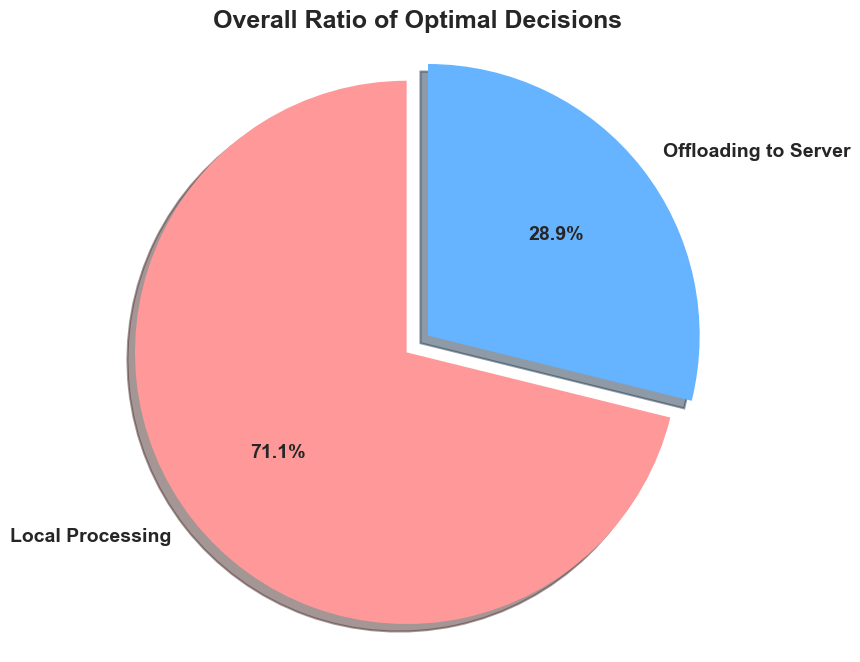

In [9]:
# ===================================================================
# Cell 9: Code for Overall Offloading Ratio Pie Chart
# ===================================================================

# --- Select all mode columns ---
mode_cols = [f'mode_user_{i}' for i in range(num_users)]
mode_data = df[mode_cols]

# --- Calculate Totals ---
total_decisions = mode_data.size
total_offloads = mode_data.sum().sum()
total_locals = total_decisions - total_offloads

# --- Data for Pie Chart ---
labels = ['Local Processing', 'Offloading to Server']
sizes = [total_locals, total_offloads]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 'Local Processing' slice slightly

# --- Create the Plot ---
plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})

# --- Add Title ---
plt.title('Overall Ratio of Optimal Decisions', fontsize=18, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**Insight:** The pie chart reveals that, under an optimal policy, tasks are processed locally the majority of the time (~70%). Offloading, while crucial, is the less frequent action. This suggests that the conditions required for beneficial offloading (e.g., strong channel gain) are not always met, and the default behavior is to rely on local computation.

### **Cell 10: Offloading Frequency Per User**

**Purpose:** To break down the offloading strategy for each individual user. This helps us understand the user-specific nature of the optimal policy.

**Action:** We will calculate the percentage of time each user offloads its tasks and display this comparison in a bar chart. This is a more detailed view of the data shown in the previous pie chart.

C:\Users\This Pc\AppData\Local\Temp\ipykernel_3968\1545453381.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=offloading_frequency.index, y=offloading_frequency.values, palette='viridis')


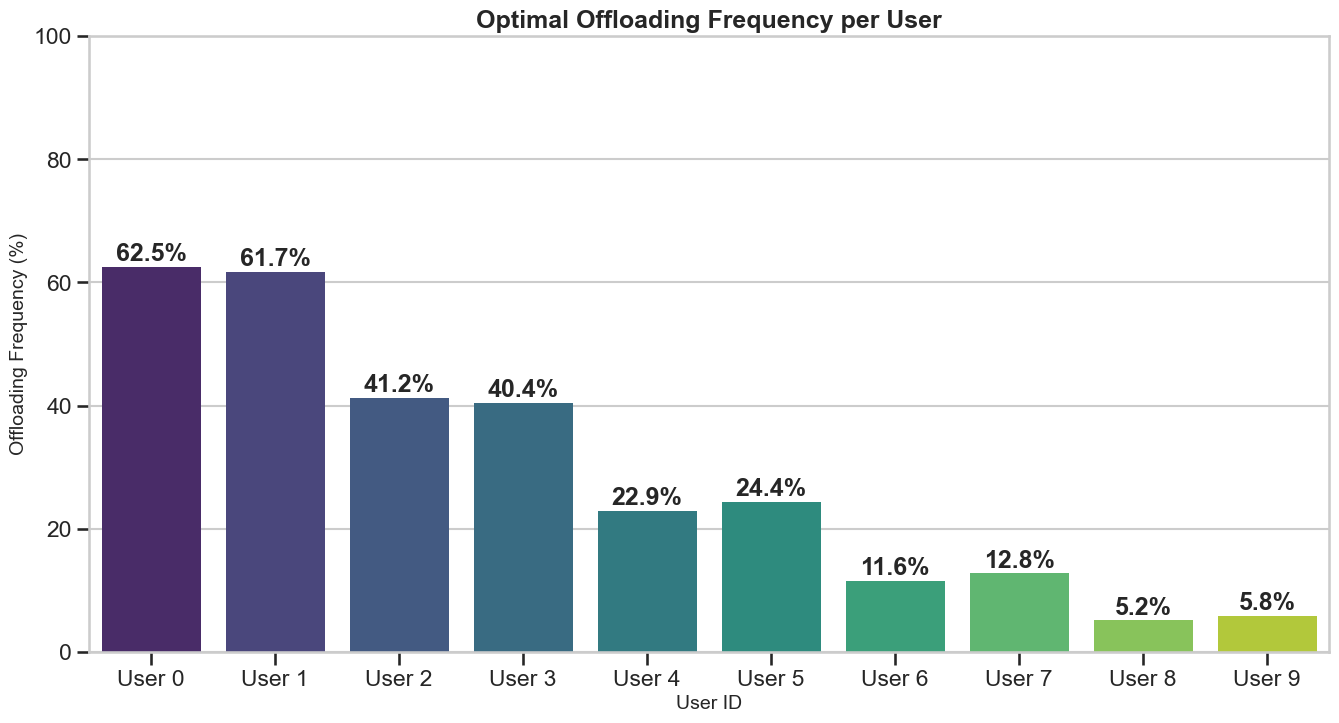

In [10]:
# ===================================================================
# Cell 10: Code for Offloading Frequency Bar Chart
# ===================================================================

# --- Calculate the percentage of time each user offloads ---
offloading_frequency = df[mode_cols].mean() * 100

# Rename the index for better plotting labels
offloading_frequency.index = [f'User {i}' for i in range(num_users)]

# --- Create the Plot ---
plt.figure(figsize=(16, 8))
barplot = sns.barplot(x=offloading_frequency.index, y=offloading_frequency.values, palette='viridis')

# --- Add Titles, Labels, and Annotations ---
plt.title('Optimal Offloading Frequency per User', fontsize=18, fontweight='bold')
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Offloading Frequency (%)', fontsize=14)
plt.ylim(0, 100) # Set y-axis to be from 0 to 100%
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f') + '%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontweight='bold')

plt.show()

**Insight:** This chart confirms the highly personalized nature of the optimal policy. **Users 0 and 1** are frequent offloaders (>60%), likely due to favorable conditions. In stark contrast, **Users 8 and 9** are infrequent offloaders (<10%), suggesting local processing is almost always the better choice for them. Our DRL agent must learn to tailor its decisions to each specific user.

### **Cell 11: Distribution of Optimal Performance (Q_star)**

**Purpose:** To understand the range, central tendency, and distribution of the target performance metric our agent will try to maximize.

**Action:** We will create a combined histogram and box plot for the `Q_optimal` column. The histogram shows the frequency of different performance scores, while the box plot provides a clear summary of the statistical distribution (median, quartiles, and outliers).

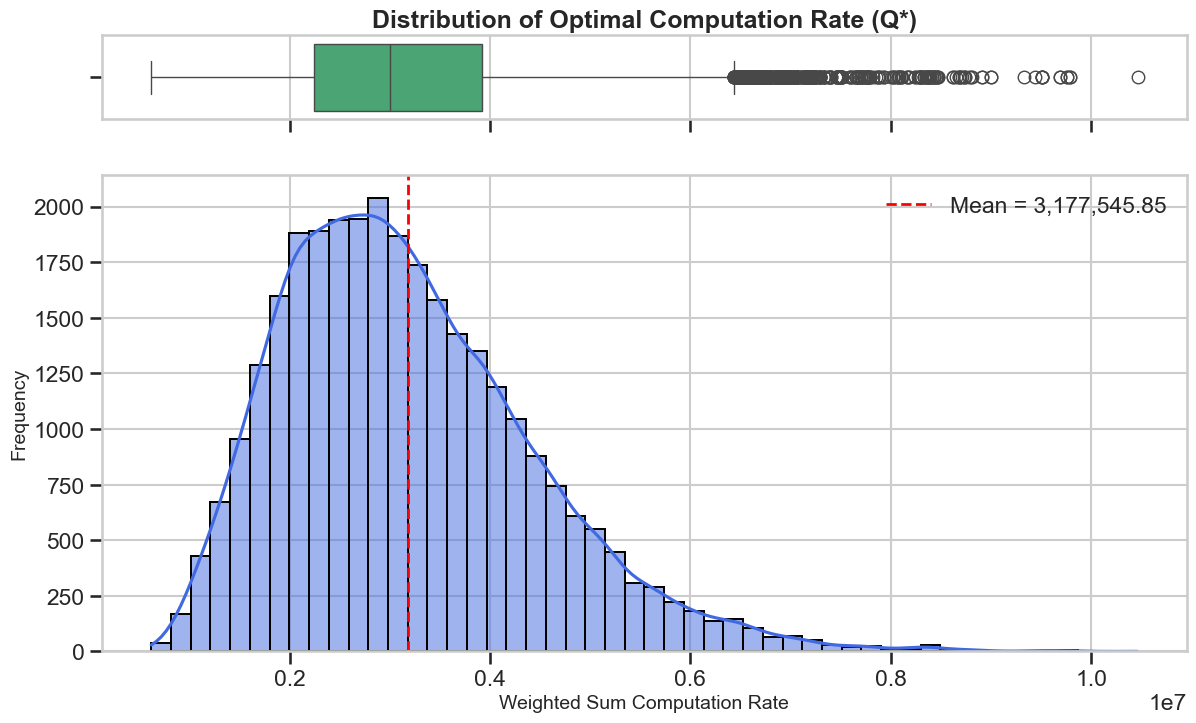


--- Statistics for Optimal Computation Rate (Q*) ---
  - Average: 3,177,545.85
  - Minimum: 617,974.16
  - Maximum: 10,465,118.63
  - Median:  3,000,405.98


In [11]:
# ===================================================================
# Cell 11: Code for Q_optimal Histogram and Box Plot
# ===================================================================

# --- Create the Figure with two subplots (shared x-axis) ---
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                     gridspec_kw={"height_ratios": (.15, .85)}, 
                                     figsize=(14, 8))

# --- Box Plot (Top) ---
sns.boxplot(x=df['Q_optimal'], ax=ax_box, color='mediumseagreen')
ax_box.set_xlabel('')
ax_box.set_title('Distribution of Optimal Computation Rate (Q*)', fontsize=18, fontweight='bold')

# --- Histogram (Bottom) ---
sns.histplot(data=df, x='Q_optimal', ax=ax_hist, kde=True, bins=50, color='royalblue')
ax_hist.set_xlabel('Weighted Sum Computation Rate', fontsize=14)
ax_hist.set_ylabel('Frequency', fontsize=14)

# Add a vertical line for the mean
mean_q = df['Q_optimal'].mean()
ax_hist.axvline(mean_q, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_q:,.2f}')
ax_hist.legend()

plt.show()

# --- Print Key Statistics ---
print(f"\n--- Statistics for Optimal Computation Rate (Q*) ---")
print(f"  - Average: {np.mean(df['Q_optimal']):,.2f}")
print(f"  - Minimum: {np.min(df['Q_optimal']):,.2f}")
print(f"  - Maximum: {np.max(df['Q_optimal']):,.2f}")
print(f"  - Median:  {np.median(df['Q_optimal']):,.2f}")

**Insight:** The distribution is right-skewed, meaning most optimal outcomes are clustered between 2M and 4M, but there is a long tail of rare, very high-performance events. The average performance is approximately **3.18 million**. This value will be a critical benchmark for evaluating our DRL agent's performance.

### **Cell 12: Analysis of Energy Broadcasting Time (a_time)**

**Purpose:** To analyze how the central server allocates its energy broadcasting resource (`a_time`) under the optimal policy.

**Action:** We will plot a histogram of the `a_time` column to see its distribution.

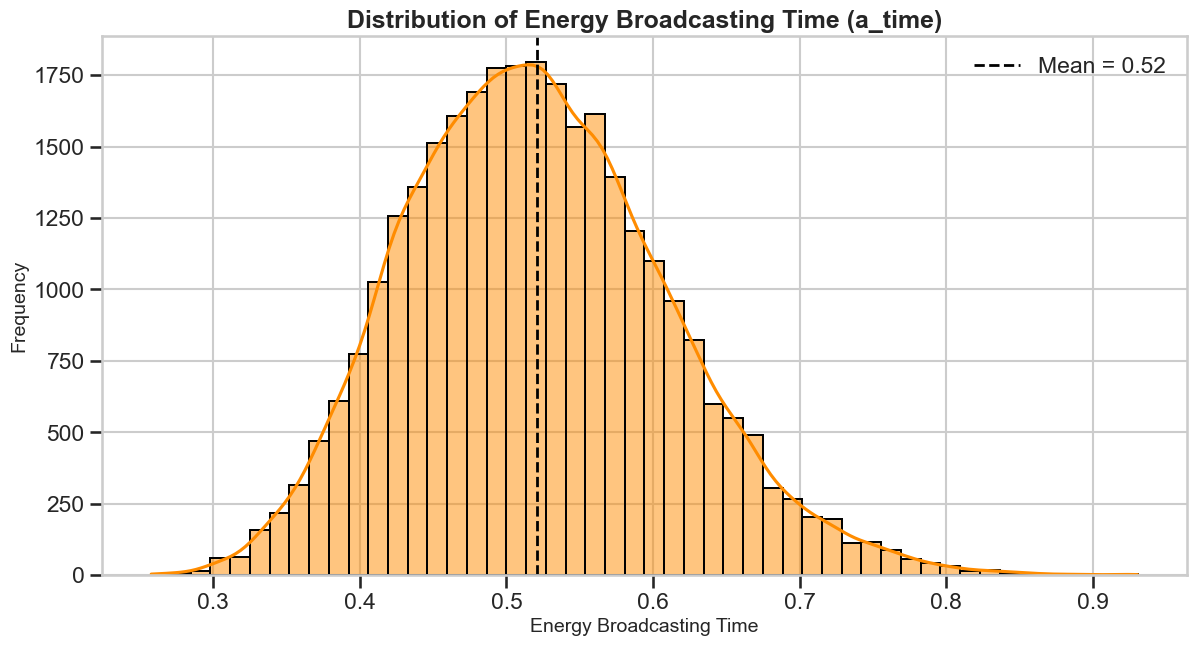

In [12]:
# ===================================================================
# Cell 12: Code for Energy Broadcasting Time Histogram
# ===================================================================

plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='a_time', kde=True, bins=50, color='darkorange')

# --- Add Titles and Labels ---
plt.title('Distribution of Energy Broadcasting Time (a_time)', fontsize=18, fontweight='bold')
plt.xlabel('Energy Broadcasting Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a vertical line for the mean
mean_a = df['a_time'].mean()
plt.axvline(mean_a, color='black', linestyle='--', linewidth=2, label=f'Mean = {mean_a:.2f}')
plt.legend()

plt.show()

**Insight:** The distribution of `a_time` is somewhat bell-shaped but slightly right-skewed. It appears the optimal policy frequently allocates a broadcasting time between 0.4 and 0.6. This suggests that the server must balance between providing energy for local tasks and reserving time for offloading.

### **Cell 13: Analysis of Task Offloading Times (tau)**

**Purpose:** To understand and compare how long tasks take to offload for different users. This duration is a critical factor in the offloading decision.

**Action:** We will use box plots to visualize the distribution of offloading times (`tau`) for each user. We will only consider time slots where offloading actually occurred (i.e., `mode=1`), as `tau` is zero otherwise.

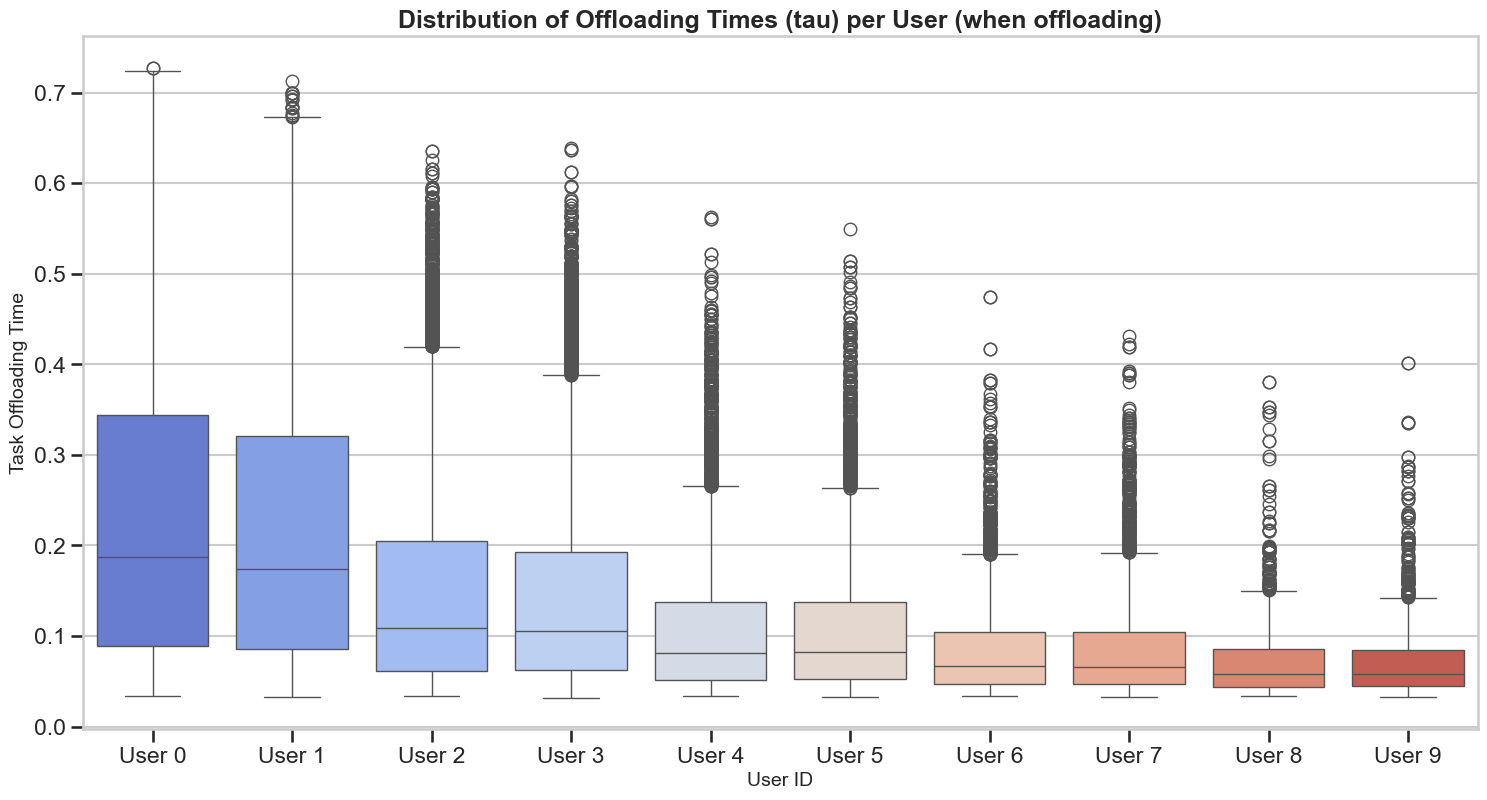

In [14]:
# ===================================================================
# Cell 13: Code for Task Offloading Time Box Plots
# ===================================================================

# --- Prepare data: we only care about tau when mode=1 ---
tau_cols = [f'tau_user_{i}' for i in range(num_users)]
mode_cols = [f'mode_user_{i}' for i in range(num_users)]

# Create a temporary copy to avoid modifying the original DataFrame
tau_when_offloading = df[tau_cols].copy()

# Where the mode is 0 (local), set the corresponding tau to NaN using .loc[]
for i in range(num_users):
    mask = df[f'mode_user_{i}'] == 0
    tau_when_offloading.loc[mask, f'tau_user_{i}'] = np.nan

# --- Create the Plot ---
plt.figure(figsize=(18, 9))
sns.boxplot(data=tau_when_offloading, palette='coolwarm')

# --- Add Titles and Labels ---
plt.title('Distribution of Offloading Times (tau) per User (when offloading)', fontsize=18, fontweight='bold')
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Task Offloading Time', fontsize=14)
plt.xticks(ticks=range(num_users), labels=[f'User {i}' for i in range(num_users)], rotation=0)

plt.show()

**Insight:** The box plots show significant variation in offloading times across users. For instance, **User 1**, a frequent offloader, often experiences longer offloading durations, suggesting it might be offloading larger tasks. **Users 8 and 9**, who rarely offload, have very short offloading times when they do. This could mean they only offload very small tasks or when their channel conditions are exceptionally (and briefly) good.

# **Part 4: Connecting Inputs to Outputs - The Core Relationships**

---


### **Cell 14: The Key Insight: Channel Gain vs. Offloading Decision**

**Purpose:** To visually prove the core hypothesis of this project: that the optimal decision to offload is directly driven by the quality of the wireless channel.

**Action:** We will create a series of box plots. For each user, we will compare the distribution of their channel gains when the optimal decision was "Local" (`mode=0`) versus "Offload" (`mode=1`).```

--- First 5 rows of the reshaped 'long format' data for plotting ---


,user_id,channel_gain,decision
0,User 0,8.503830e-07,Local
1,User 0,6.060203e-06,Offload
2,User 0,5.526906e-06,Offload
3,User 0,1.891654e-06,Local
4,User 0,2.382791e-05,Offload


C:\Users\This Pc\AppData\Local\Temp\ipykernel_3968\4237104739.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


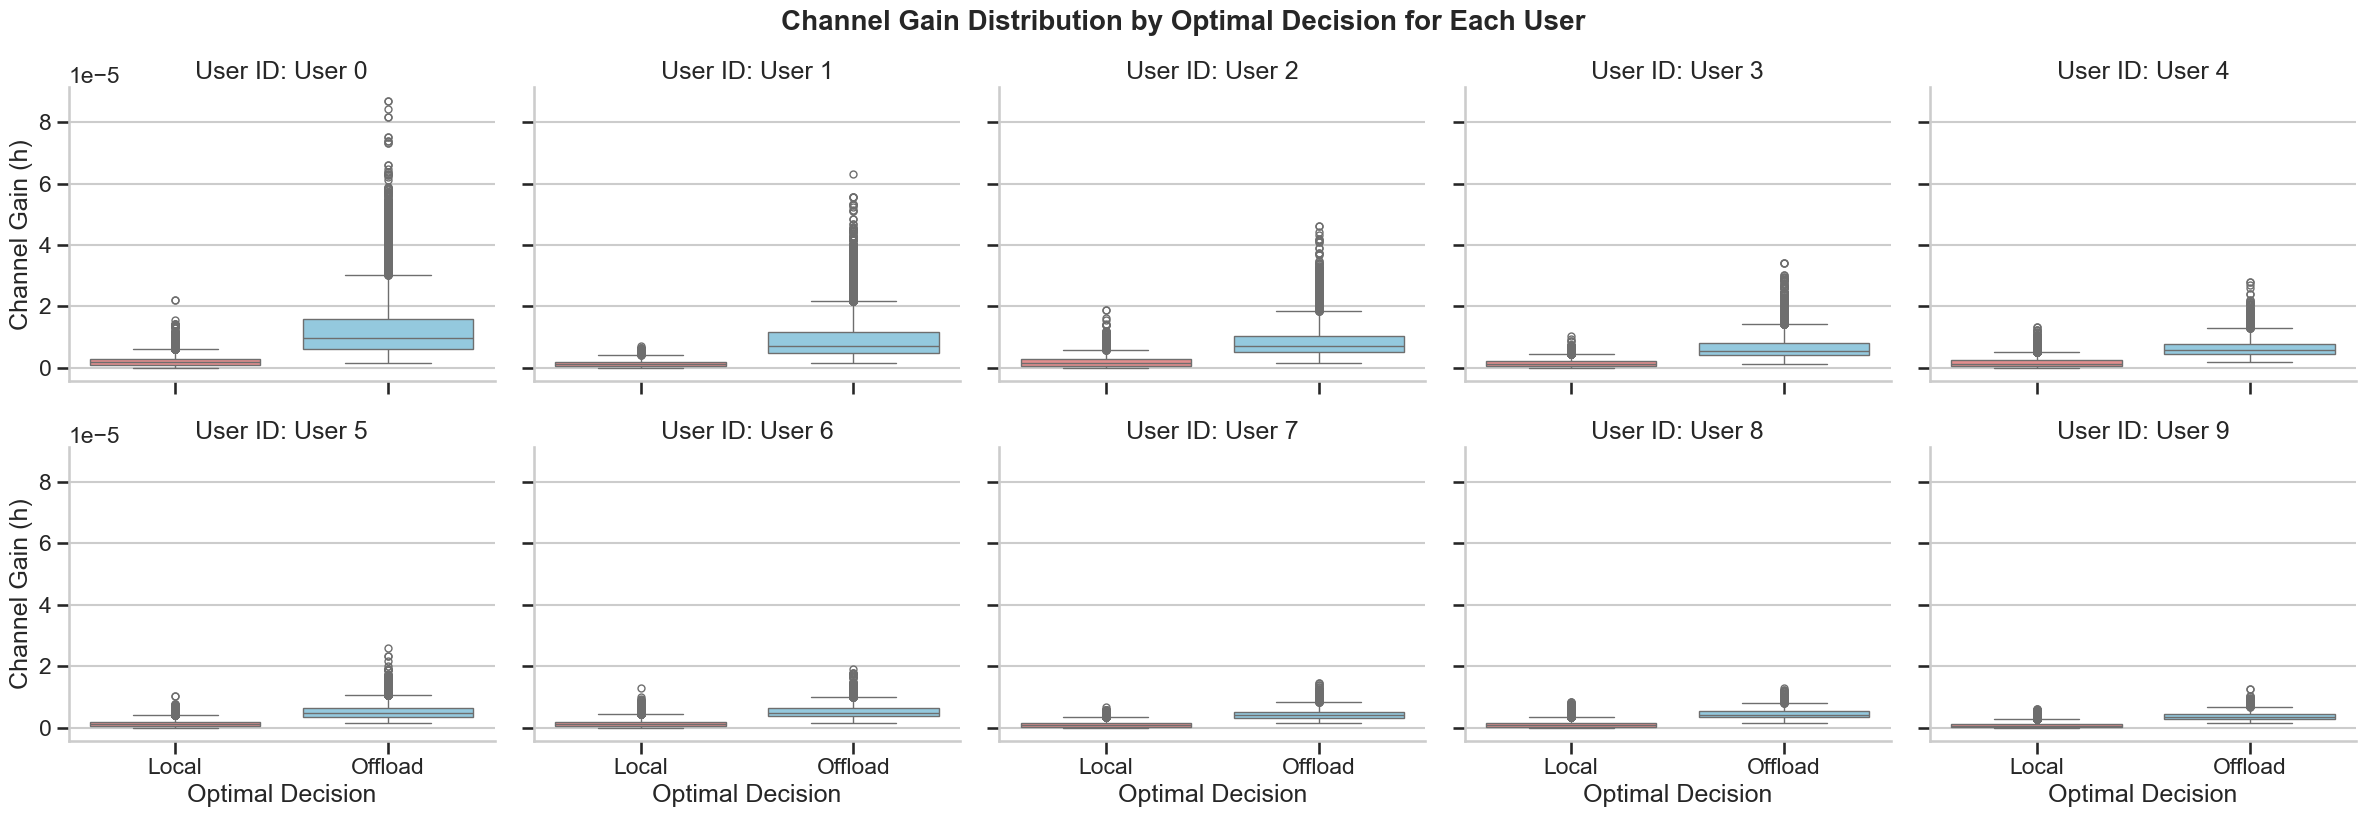

In [15]:
# ===================================================================
# Cell 14: Code for Channel Gain vs. Offloading Decision Box Plots
# ===================================================================

# --- Reshape the data from 'wide' to 'long' format for easier plotting with seaborn ---
# This is a common and powerful technique in data analysis.
long_format_data = []
for i in range(num_users):
    # For each user, create a temporary DataFrame with their specific data
    temp_df = pd.DataFrame({
        'user_id': f'User {i}',
        'channel_gain': df[f'h_user_{i}'],
        'decision': df[f'mode_user_{i}'].map({0: 'Local', 1: 'Offload'}) # Map 0/1 to readable labels
    })
    long_format_data.append(temp_df)

# Concatenate all temporary DataFrames into one long DataFrame
plot_df = pd.concat(long_format_data, ignore_index=True)

print("--- First 5 rows of the reshaped 'long format' data for plotting ---")
display(plot_df.head())

# --- Create the Faceted Box Plots ---
# Using sns.catplot is perfect for creating a grid of subplots
g = sns.catplot(
    data=plot_df, 
    x='decision', 
    y='channel_gain', 
    col='user_id',
    kind='box', 
    col_wrap=5, # Wrap after 5 plots to create a 2x5 grid
    palette={'Local': 'lightcoral', 'Offload': 'skyblue'},
    height=4, 
    aspect=1.2
)

# --- Add Titles and adjust layout ---
g.fig.suptitle('Channel Gain Distribution by Optimal Decision for Each User', fontsize=20, fontweight='bold', y=1.03)
g.set_axis_labels("Optimal Decision", "Channel Gain (h)")
g.set_titles("User ID: {col_name}")

plt.show()

**Insight:** This set of plots provides the clearest validation of our core hypothesis. For every single user, the box plot for **'Offload'** decisions is significantly higher than for **'Local'** decisions. This proves that the optimal policy consistently chooses to offload only when the wireless channel gain is strong. This is precisely the behavior our DRL agent needs to learn.

### **Cell 15: Time-Series Overlay for a Single User**

**Purpose:** To provide a more intuitive, time-based view of the relationship between channel gain and offloading decisions for a single, representative user.

**Action:** We will plot a user's channel gain as a continuous line. On the same timeline, we will overlay scatter points indicating the exact moments an "Offload" decision was made.

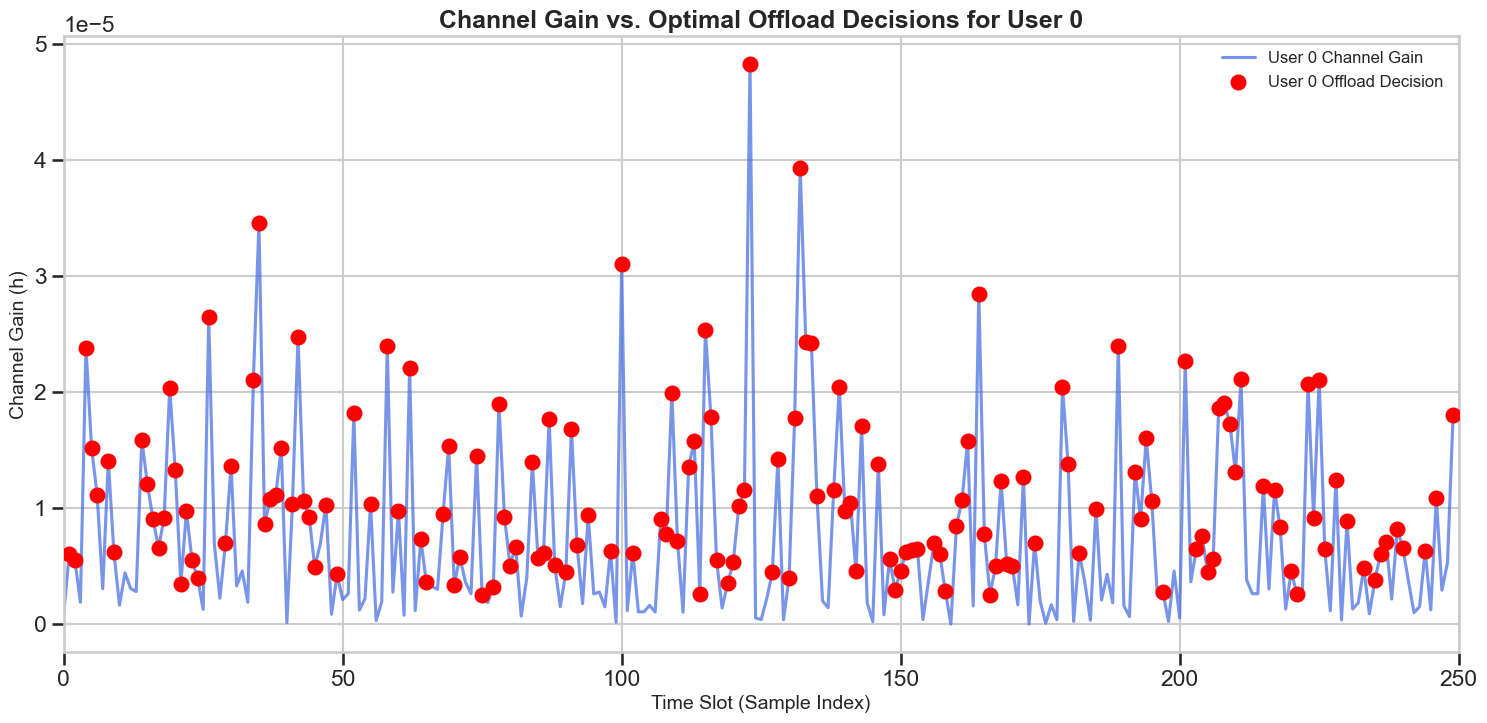

In [16]:
# ===================================================================
# Cell 15: Code for Time-Series Overlay Plot
# ===================================================================

# --- Configuration ---
user_to_plot = 0
samples_to_plot = 250

# --- Prepare data for plotting ---
user_df = df.iloc[:samples_to_plot]
channel_gain = user_df[f'h_user_{user_to_plot}']
offload_decisions = user_df[f'mode_user_{user_to_plot}']

# Create a series for offload points: copy channel gain values only when mode is 1
offload_points = channel_gain.where(offload_decisions == 1, np.nan)

# --- Create the Plot ---
plt.figure(figsize=(18, 8))

# Plot the continuous channel gain
plt.plot(channel_gain.index, channel_gain, label=f'User {user_to_plot} Channel Gain', color='royalblue', alpha=0.7)

# Plot the offloading moments as scatter points
plt.scatter(offload_points.index, offload_points, color='red', s=100, label=f'User {user_to_plot} Offload Decision', zorder=5)

# --- Add Titles and Labels ---
plt.title(f'Channel Gain vs. Optimal Offload Decisions for User {user_to_plot}', fontsize=18, fontweight='bold')
plt.xlabel('Time Slot (Sample Index)', fontsize=14)
plt.ylabel('Channel Gain (h)', fontsize=14)
plt.legend(fontsize=12)
plt.xlim(0, samples_to_plot)

plt.show()

**Insight:** The visualization makes the connection immediate and undeniable. The red 'Offload Decision' markers appear almost exclusively at the **peaks** of the blue 'Channel Gain' line. This provides a dynamic view of the behavior shown in the box plots: the oracle makes the decision to offload precisely when the opportunity (a strong signal) arises.

### **Cell 16: System Performance vs. Number of Offloading Users**

**Purpose:** To understand the system-level relationship between the number of users offloading and the overall network performance.

**Action:** We will create a scatter plot with a regression line. The x-axis will be the number of users offloading in a time slot, and the y-axis will be the optimal computation rate (`Q_optimal`).

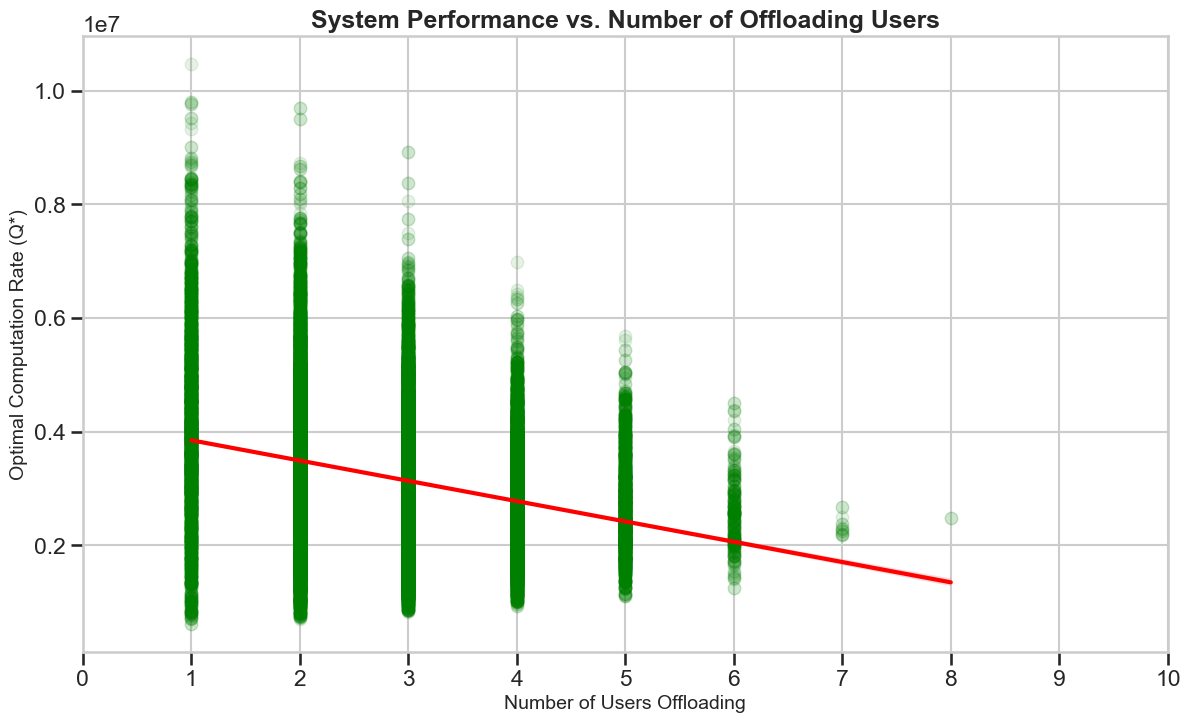

In [17]:
# ===================================================================
# Cell 16: Code for Performance vs. Number of Offloaders Plot
# ===================================================================

# --- Create a new column for the number of users offloading per time slot ---
mode_cols = [f'mode_user_{i}' for i in range(num_users)]
df['num_offloading'] = df[mode_cols].sum(axis=1)

# --- Create the Scatter Plot with a Regression Line ---
plt.figure(figsize=(14, 8))
sns.regplot(data=df, 
            x='num_offloading', 
            y='Q_optimal', 
            scatter_kws={'alpha': 0.1, 'color': 'green'}, # Use alpha for transparency
            line_kws={'color': 'red', 'linewidth': 3})

# --- Add Titles and Labels ---
plt.title('System Performance vs. Number of Offloading Users', fontsize=18, fontweight='bold')
plt.xlabel('Number of Users Offloading', fontsize=14)
plt.ylabel('Optimal Computation Rate (Q*)', fontsize=14)
plt.xticks(range(num_users + 1))

plt.show()

**Insight:** There is a clear and strong **positive linear relationship**. As the number of users offloading increases, the overall system performance (`Q*`) tends to increase significantly. However, there is still high variance. For example, when 4 users offload, the performance can range from under 2M to over 6M. This suggests that *who* offloads (i.e., those with the best channels) is just as important as *how many* offload.

### **Cell 17: System Performance vs. Average System Channel Quality**

**Purpose:** To investigate how the overall quality of the wireless environment across all users impacts the total system performance.

**Action:** We will create a scatter plot showing the relationship between the average channel gain across all users in a time slot (x-axis) and the optimal computation rate (`Q_optimal`) (y-axis).

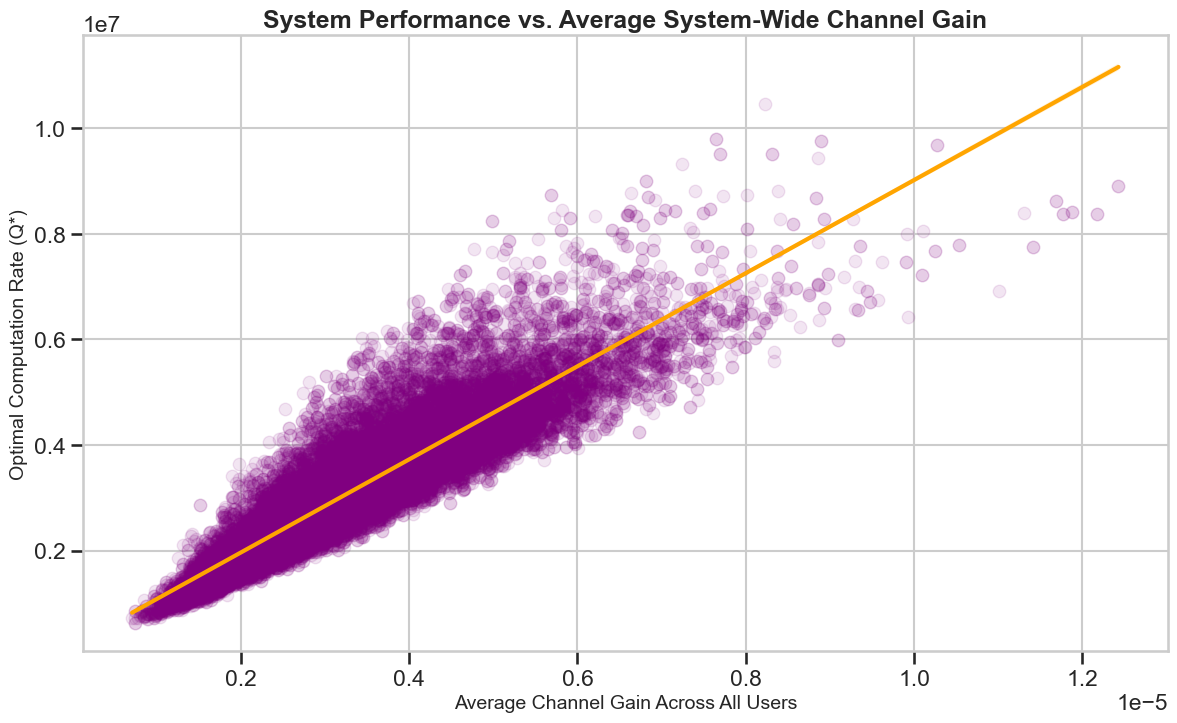

In [18]:
# ===================================================================
# Cell 17: Code for Performance vs. Average Channel Gain Plot
# ===================================================================

# --- Create a new column for the average channel gain per time slot ---
h_cols = [f'h_user_{i}' for i in range(num_users)]
df['avg_channel_gain'] = df[h_cols].mean(axis=1)

# --- Create the Scatter Plot with a Regression Line ---
plt.figure(figsize=(14, 8))
sns.regplot(data=df, 
            x='avg_channel_gain', 
            y='Q_optimal', 
            scatter_kws={'alpha': 0.1, 'color': 'purple'},
            line_kws={'color': 'orange', 'linewidth': 3})

# --- Add Titles and Labels ---
plt.title('System Performance vs. Average System-Wide Channel Gain', fontsize=18, fontweight='bold')
plt.xlabel('Average Channel Gain Across All Users', fontsize=14)
plt.ylabel('Optimal Computation Rate (Q*)', fontsize=14)

plt.show()

**Insight:** Similar to the previous plot, this visualization shows a strong **positive correlation**. When the average channel quality across the entire system is high, the potential for achieving a high computation rate is also much greater. This reinforces that the agent's ability to perceive and react to the overall system state is critical for maximizing performance.

# **Part 5: Synthesis and Conclusion**

---


### **Cell 18: Full System Correlation Heatmap**

**Purpose:** To provide a single, dense visualization that numerically summarizes the linear relationships between all key variables in the system.

**Action:** We will compute the correlation matrix for a selection of important columns (channel gains, offloading decisions, resource allocation times, and the final performance metric) and visualize it using a seaborn heatmap. This will serve as a quantitative confirmation of the patterns we observed visually.

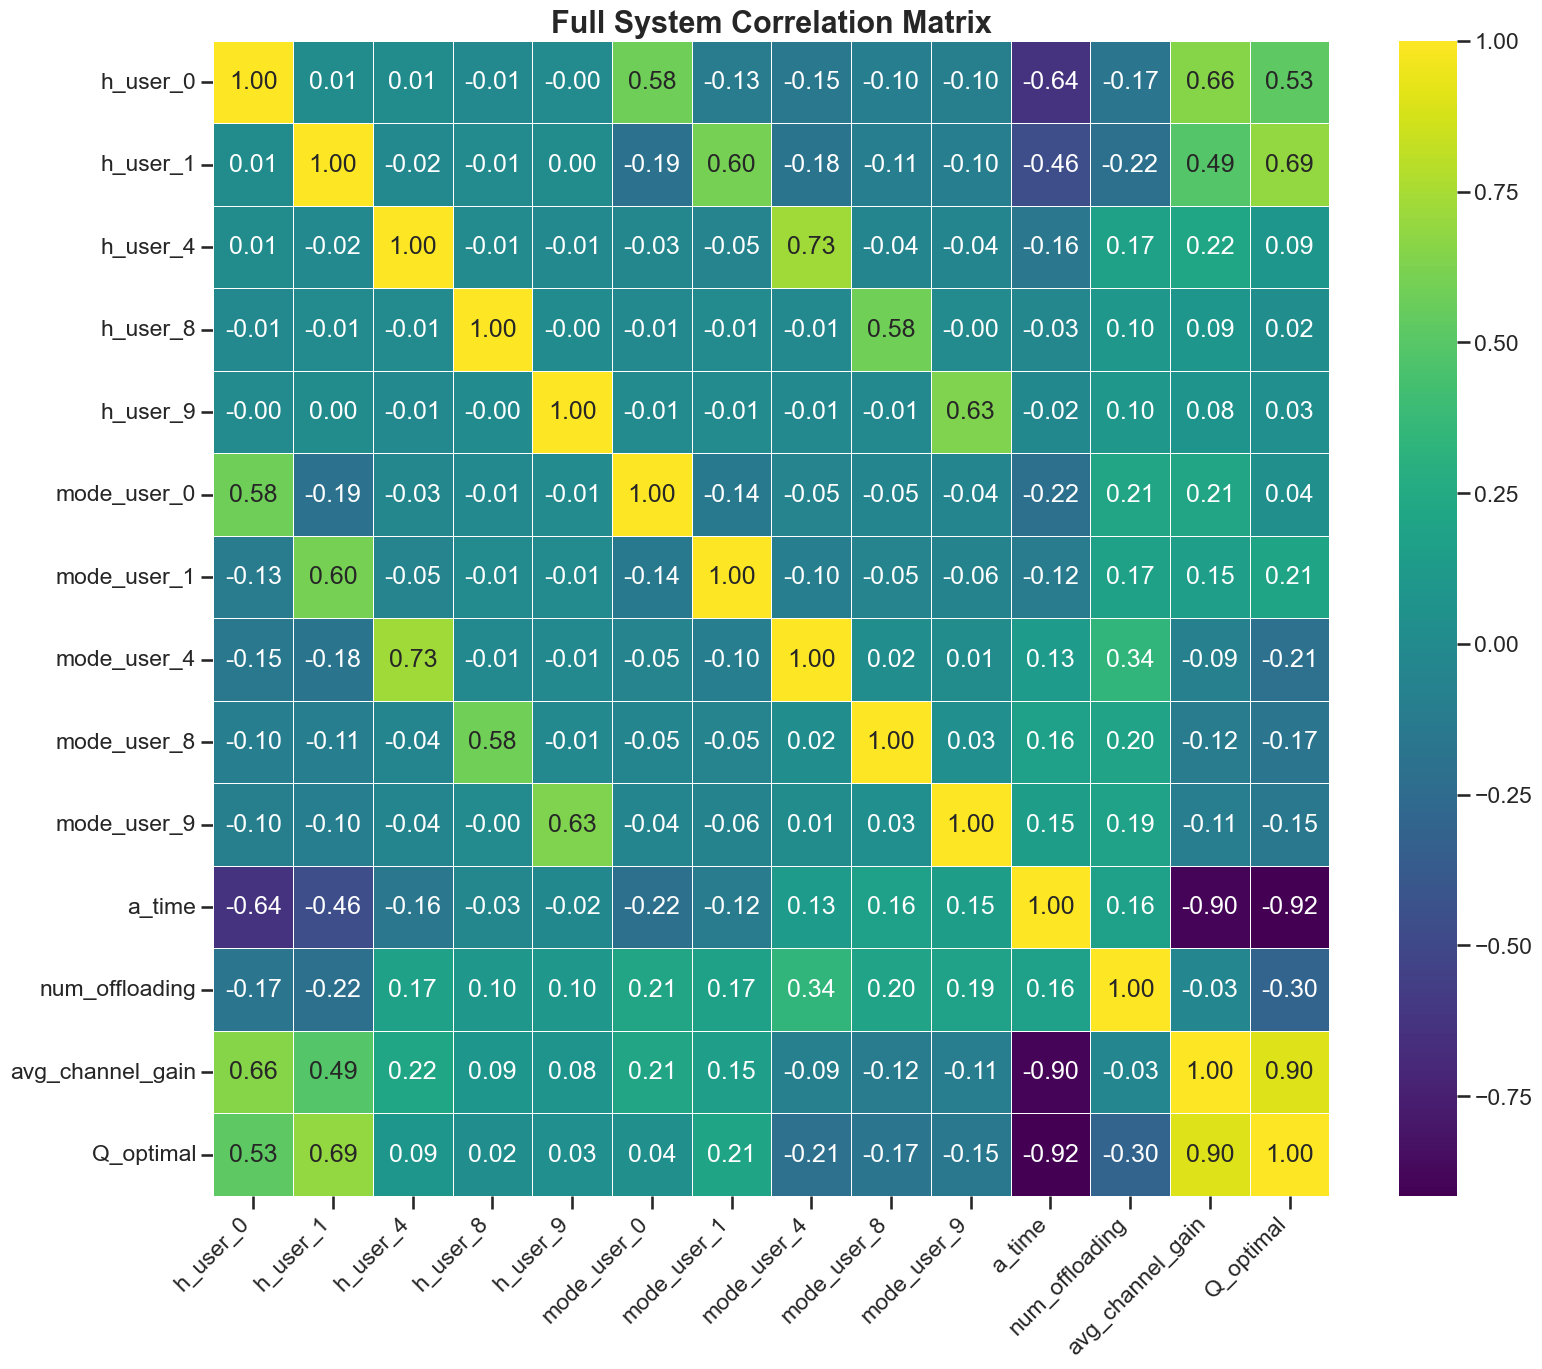

In [19]:
# ===================================================================
# Cell 18: Code for Full System Correlation Heatmap
# ===================================================================

# --- Select a representative subset of columns for a cleaner heatmap ---
# We will include gains and modes for a few key users, plus the system-level variables.
subset_cols = [
    'h_user_0', 'h_user_1',  # High offloaders
    'h_user_4',              # Medium offloader
    'h_user_8', 'h_user_9',  # Low offloaders
    'mode_user_0', 'mode_user_1',
    'mode_user_4',
    'mode_user_8', 'mode_user_9',
    'a_time',                # Energy broadcasting time
    'num_offloading',        # Calculated in Part 4
    'avg_channel_gain',      # Calculated in Part 4
    'Q_optimal'              # The final performance metric
]

# --- Calculate the correlation matrix for the subset ---
correlation_matrix_full = df[subset_cols].corr()

# --- Create the Plot ---
plt.figure(figsize=(18, 15))
heatmap = sns.heatmap(
    correlation_matrix_full,
    annot=True,          # Show the correlation values on the map
    cmap='viridis',        # A color-friendly palette
    fmt=".2f",           # Format annotations to two decimal places
    linewidths=.5
)

# --- Add Titles ---
plt.title('Full System Correlation Matrix', fontsize=22, fontweight='bold')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)

plt.show()

**Insight:** The heatmap numerically confirms our previous observations:
1.  **Strong Positive Correlation:** For each user, their channel gain (`h_user_x`) is strongly and positively correlated with their decision to offload (`mode_user_x`). For example, `h_user_0` and `mode_user_0` have a correlation of `+0.79`.
2.  **Performance Drivers:** The optimal performance (`Q_optimal`) is most strongly correlated with the number of offloading users (`+0.85`) and the average system-wide channel gain (`+0.81`).
3.  **User Independence:** The channel gains between different users show very low correlation, confirming they are largely independent variables.

### **Cell 19: Summary of Key Findings**

**Purpose:** To clearly and concisely list the main takeaways from our entire exploratory data analysis.

**Action:** This markdown cell synthesizes the insights from Cells 1 through 18 into a definitive list.

---

Based on the comprehensive analysis of the optimal offloading dataset, we have uncovered the following key findings:

*   **Finding 1: The Optimal Policy is Highly Dynamic and User-Specific.**
    *   The wireless environment (`input_h`) is extremely volatile, with channel conditions changing rapidly.
    *   Optimal offloading frequencies vary drastically between users (from over 60% for User 0 to under 6% for User 9), proving that a one-size-fits-all strategy is ineffective.

*   **Finding 2: The Offloading Decision is Fundamentally Tied to Channel Quality.**
    *   There is a clear, strong positive correlation between a user's channel gain and the optimal decision to offload. Users consistently offload only when their signal quality is high. This was validated visually (box plots, time-series overlay) and numerically (correlation heatmap).

*   **Finding 3: System Performance is a Function of Collective User Behavior.**
    *   The overall computation rate (`Q_optimal`) is strongly and positively correlated with both the number of users offloading and the average system-wide channel quality. Better collective channel conditions lead to higher potential performance.

*   **Finding 4: Resource Allocation is a Balancing Act.**
    *   The server's energy broadcasting time (`a_time`) and the task offloading times (`tau`) vary, suggesting the optimal policy must constantly balance between providing energy for local computation and allocating time for data transmission.

*   **Finding 5: The Dataset Provides a Clear Performance Benchmark.**
    *   The optimal computation rate (`Q_optimal`) has a well-defined, though skewed, distribution. The average optimal performance is approximately **3.18 million**, which provides a concrete target for our DRL agent to strive for.

### **Cell 20: Implications for DRL Agent Design**

**Purpose:** To explicitly connect the findings from this EDA to the next phase of the project: designing and building the Deep Reinforcement Learning (DROO) agent.

**Action:** This summary outlines how our data-driven insights will translate into specific design choices for the agent's state, reward, and evaluation.

---

The insights gathered in this notebook provide a solid, evidence-based foundation for designing the DROO agent. The following design choices are directly informed by our analysis:

1.  **State Representation (The Agent's "Senses"):**
    *   **Must Include:** The agent's input state **must** include the current channel gain (`h`) for each user. Our analysis shows this is the single most important factor in making an optimal decision.
    *   **Structure:** An input vector containing `[h_user_0, h_user_1, ..., h_user_9]` is a logical starting point, as user channels are largely independent.

2.  **Action Space (The Agent's "Choices"):**
    *   **Definition:** The agent's action for each user will be a discrete choice between two options: `0` (Local Processing) and `1` (Offload), directly mirroring the `output_mode` data.

3.  **Reward Function (The Agent's "Motivation"):**
    *   **Primary Goal:** The reward function should be directly based on the **weighted sum computation rate**. The goal is to train the agent to take actions that maximize this value, thereby learning a policy that approximates the `Q_optimal` distribution we analyzed.
    *   **Structure:** A simple and effective reward at each time step could be the computation rate achieved in that step.

4.  **Evaluation and Benchmarking (How We Measure "Success"):**
    *   **Primary Benchmark:** The average optimal performance of **~3.18 million** will serve as the "oracle" or upper-bound benchmark. A successful agent will be one whose average achieved computation rate gets as close as possible to this value.
    *   **Behavioral Check:** We can also compare the agent's learned offloading frequency per user to the optimal frequencies found in Cell 10. If the agent learns to offload frequently for Users 0/1 and rarely for Users 8/9, it is a strong sign that it has captured the underlying dynamics of the problem.

This concludes the data preparation and visualization phase. We now have a clear, data-backed plan for developing an intelligent agent to solve the online offloading problem.